### Random Model



In [ ]:
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import wrappers, logger


EPISODES = 500
ALL_SCORES = np.zeros(EPISODES)

env = gym.make("MsPacman-ram-v0")
env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)

for episode in range(EPISODES):
    env.reset()
    
    reward, info, done = None, None, None

    
    total_score = 0
    while done != True:
        env.render()
        random_action = env.action_space.sample()
        state, reward, done, info = env.step(random_action)
        total_score += reward
    ALL_SCORES[episode] = total_score
    print("Total Score: {}".format(total_score))
    # print(state, reward, done, info)
    
env.close()
plt.plot(ALL_SCORES)
plt.title("Random Agent: {} Episodes".format(EPISODES))
plt.show()

print("-------------------------")
print('Average Score for {} Episodes: {}'.format(EPISODES, np.mean(ALL_SCORES)))


Total Score: 350.0
Total Score: 250.0
Total Score: 160.0
Total Score: 170.0


v2- corrected reward (0.01 LR, batch size 256, min epsilon 0.05, episilon decay 0.9999)  
v2- corrected reward (0.05 LR, batch size 256, min epsilon 0.0, episilon decay 0.99999), increased memeory from 2000 to 10000

BOTH STILL GET STUCK

## Training Model

In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers


# DQN Agent for the MsPacman
# it uses Neural Network to approximate q function and replay memory & target q network
class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see MsPacman learning, then change to True
        self.render = True
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.05
        self.epsilon = 1.0
        self.epsilon_decay = 0.99999
        self.epsilon_min = 0.0
        self.batch_size = 256
        self.train_start = 1000
        
        # create replay memory using deque
        self.memory = deque(maxlen=10000)

        # create main model
        self.model = self.build_model()

        if self.load_model:
            self.model.load_weights("./Saved Weights/pacman.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):

        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
#         total_training_steps += batch_size

        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #STATE
            action.append(mini_batch[i][1])    #ACTION
            reward.append(mini_batch[i][2])    #REWARD
            update_target[i] = mini_batch[i][3]#NEXT STATE
            done.append(mini_batch[i][4])      #DONE

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)


        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))
#         print(update_input, update_target)

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
        


if __name__ == "__main__":
    EPISODES = 1000
    env = gym.make('MsPacman-ram-v0')
    env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)
    
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        lives = 3
        while not done: 
            dead = False         
            while not dead:
                if agent.render:
                    env.render()

                # get action for the current state and go one step in environment
                action = agent.get_action(state)
                next_state, reward, done, info = env.step(action)
                reward = reward if not dead else -1000  # if action make Pacman dead, then gives penalty of -100
                next_state = np.reshape(next_state, [1, state_size])
                
               
                
                
                # save the sample <s, a, r, s'> to the replay memory
                agent.append_sample(state, action, reward, next_state, done)
                
                # every time step do the training
                agent.train_model()

                state = next_state            
                score += reward
                dead = info['ale.lives'] < lives
                lives = info['ale.lives']
                


            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./pacman.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
    #         # save the model
        if e % 2 == 0:
            agent.model.save_weights("./Saved Weights/pacman_correctedv11.h5")

#     print("Total Training Steps: {}".format(total_training_steps))


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 25,353
Trainable params: 25,353
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 440.0   memory length: 1060   epsilon: 0.9894559295807855
episode: 1   score: 170.0   memory length: 1688   epsilon: 0.9832615859682241
episode: 2   score: 120.0   memory length: 2185   epsilon: 0.9783868752028313
episode: 3   score: 270.0   memory length: 2860   epsilon: 0.9718049698071488
episode: 4   score: 240.0   memory length: 3567   epsilon: 0.9649585052090569
episode: 5  

KeyboardInterrupt: 

### FINDING

The Pacman learns to just stay in the corner after consuming the "Power Pellets" since the reward from consuming ghosts outweight the negative reward of dying. Must increase the negative reward from dying.

The learned weights will be in 'correctedv1.h5'

# Code to Test Trained Weights- No Training Involved

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 585       
Total params: 25,353
Trainable params: 25,353
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 460.0
episode: 1   score: 560.0
episode: 2   score: 440.0


KeyboardInterrupt: 

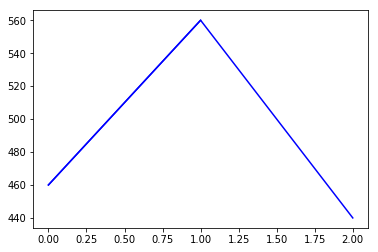

In [3]:
# DQN Agent for the MsPacman
# it uses Neural Network to approximate q function and replay memory & target q network
class TEST_DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see MsPacman learning, then change to True
        self.render = True
        self.load_model = True
        self.epsilon = 0.1

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # create main model
        self.model = self.build_model()

        if self.load_model:
            self.model.load_weights("./Saved Weights/pacman_correctedv10.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam())
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
#         q_value = self.model.predict(state)
#         return np.argmax(q_value[0])
        
        
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers
import matplotlib.pyplot as plt


if __name__ == "__main__":
    EPISODES = 100
    ALL_SCORES = np.zeros(EPISODES)

    env = gym.make('MsPacman-ram-v0')
    env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = TEST_DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        lives = 3
        while not done: 
            dead = False         
            while not dead:
                if agent.render:
                    env.render()

                # get action for the current state and go one step in environment
                action = agent.get_action(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state, [1, state_size])

                state = next_state            
                score += reward
                dead = info['ale.lives']<lives
                lives = info['ale.lives']
                # if an action make the Pacman dead, then gives penalty of -100
                reward = reward if not dead else -500

            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./pacman.png")
                print("episode:", e, "  score:", score)
        
        ALL_SCORES[e] = score
                
    env.close()
    plt.plot(ALL_SCORES)
    plt.title("Random Agent: {} Episodes".format(EPISODES))
    plt.show()

    print("-------------------------")
    print('Average Score for {} Episodes: {}'.format(EPISODES, np.mean(ALL_SCORES)))